In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functions_anisotropy import *
from scipy.signal import butter,filtfilt,lfilter

In [2]:
medium = load_medium_list()

#0 isotropic
#1 taylor sandstone
#2 mesaverde clayshale
#3 mesaverde laminated siltstone
#4 mesaverde mudshale
#5 mesaverde calcareous sandstone
#6 quartz


In [3]:
index = 1
C, density = get_specific_VTI(medium[index])
#C, density = get_random_C('triclinic',30)

taylor sandstone
[[34.5974432   9.34087365 10.61386654  0.          0.          0.        ]
 [ 9.34087365 34.5974432  10.61386654  0.          0.          0.        ]
 [10.61386654 10.61386654 28.35856     0.          0.          0.        ]
 [ 0.          0.          0.          8.3631025   0.          0.        ]
 [ 0.          0.          0.          0.          8.3631025   0.        ]
 [ 0.          0.          0.          0.          0.         12.62828478]]


In [4]:
def awgn(x,SNR_dB):
    L = x.size
    SNR = 10**(SNR_dB/10)                  # SNR to linear scale
    Esym = np.sum(abs(x)**2,axis=None)/(L) # calculate actual symbol energy
    N0 = Esym / SNR                        # find the noise spectral density
    noiseSigma = np.sqrt(N0)               # standard deviation for AWGN Noise
    n = noiseSigma * np.random.randn(x[:,0].size,x[0,:].size) #computed noise
    return x + n                           # received signal

def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    y = lfilter(b, a, data)
    return y


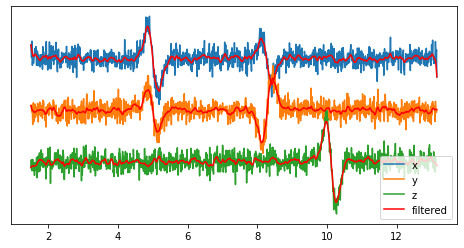

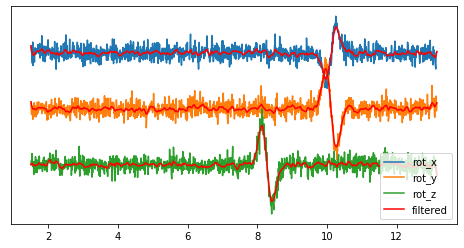

In [5]:
f = 5.
SNR_dB = 1
filt = 'LP' #'BP'
fmin = 1.
fmax = 9.
order = 1 


### generating some traces
nus, gammas = get_direction('random',C,1)
vel,v = get_eigenvals(gammas[0], density)
seis, t = get_seis(v, vel, nus[0], f)
#make some noise
seis_noise = np.zeros((6,len(seis[0,:])))
seis_noise[0:3] = awgn(seis[0:3],SNR_dB)
seis_noise[3:6] = awgn(seis[3:6],SNR_dB)

fs = len(seis_noise[0,:])/(t[-1]-t[0]) #sampling rate
seis_fil = np.zeros((6,len(seis[0,:])))

#either bandpass or lowpass filter
for i in range(0,6):
    if filt=='LP':
        seis_fil[i,:] = butter_lowpass_filter(seis_noise[i,:], f, fs,order )
    elif filt=='BP':    
        seis_fil[i,:] = butter_bandpass_filter(seis_noise[i,:],fmin,fmax,fs,order)
    else:
        print('Not implemented filter!')
        

# plot results
a1 = abs(seis_noise[0:3][:].max())
plt.figure(figsize=(8,4))
plt.plot(t,seis_noise[0,:],label='x')
plt.plot(t,seis_noise[1,:]-a1,label='y')
plt.plot(t,seis_noise[2,:]-2*a1,label='z')
plt.plot(t,seis_fil[0,:],color='red',label='filtered')
plt.plot(t,seis_fil[1,:]-a1,color='red')
plt.plot(t,seis_fil[2,:]-2*a1,color='red')
plt.legend()
plt.yticks([])
plt.show()

a2 = seis_noise[3:6][:].max()
plt.figure(figsize=(8,4))
plt.plot(t,seis_noise[3,:],label='rot_x')
plt.plot(t,seis_noise[4,:]-a2,label='rot_y')
plt.plot(t,seis_noise[5,:]-2*a2,label='rot_z')
plt.plot(t,seis_fil[3,:],color='red',label='filtered')
plt.plot(t,seis_fil[4,:]-a2,color='red')
plt.plot(t,seis_fil[5,:]-2*a2,color='red')
plt.legend()
plt.yticks([])
plt.show()
